Here is an example of loading up the baseline simualtion and returning information about the visits that overlap a single point in the sky.

Installation instructions for rubin_sim can be found in the README at: https://github.com/lsst/rubin_sim

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

In [2]:
# Grab the current baseline file. Should have been downloaded with rubin_sim. 
# Can grab lots of different sims from: http://astro-lsst-01.astro.washington.edu:8081/
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
conn = maf.db.OpsimDatabase(baseline_file)
outDir = 'temp'
resultsDb = maf.db.ResultsDb(outDir=outDir)

In [4]:
bundleList = []
# The point on the sky we would like to get visits for
ra = [0.]
dec = [-20]


# Say we just want to pass data through, not compute anything. Documentation on the columns coming soon.
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
# Select all the visits
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name))

In [5]:
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying table None with no constraint for columns ['filter', 'fieldRA', 'fieldDec', 'observationStartMJD', 'rotSkyPos', 'fiveSigmaDepth'].
Found 2086980 visits
Running:  ['baseline_v2_0_10yrs_Pass_filter_observationStartMJD_fiveSigmaDepth_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [6]:
# Our bundleList now has values. The trailing [0] is to get the first result. If we specified more
# ra,dec point, those results would be in the later indices.
bundleList[0].metricValues[0]

rec.array([('r', 3.59778461e+02, -21.51224265, 63011.43508492, 192.00897458, 23.23263915),
           ('z', 3.59588617e+02, -21.36456019, 60547.40867669, 214.14209374, 22.70303423),
           ('z', 3.59609471e+02, -21.53658271, 63523.23867258, 175.6891119 , 22.01368241),
           ('r', 3.59726197e+02, -21.66912236, 61293.3558996 , 219.92337235, 23.21584619),
           ('i', 3.59588617e+02, -21.36456019, 60547.32509468, 206.3716141 , 23.38748783),
           ('u', 3.59078721e+02, -21.5990567 , 63858.15512221,  87.74909379, 23.07295284),
           ('y', 3.59224461e+02, -21.36448985, 62720.42436354, 319.61122742, 21.94190937),
           ('z', 3.59741584e+02, -21.85855496, 61250.28508315, 119.84901049, 22.73975315),
           ('r', 3.59257210e+02, -21.5969847 , 60939.26788802, 233.9291994 , 24.09989625),
           ('i', 3.59821854e+02, -21.65400137, 63087.39522233, 171.60173491, 22.9757672 ),
           ('r', 3.59821854e+02, -21.65400137, 63087.38366757, 169.75099761, 23.09939887),

Text(0.5, 1.0, 'baseline_v2.0_10yrs\nObservations at ra=0.000, dec=-20.000')

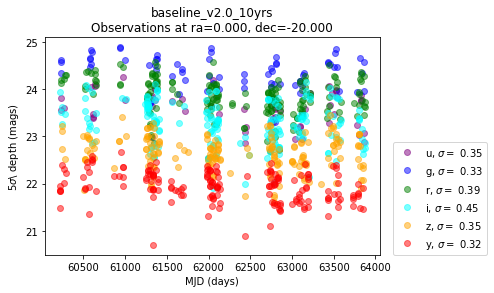

In [7]:
# As a bit of foreshadowing for how the rest of MAF works, we'll call the visits overlapping a
# single point in the sky "dataSlice". 
dataSlice = bundleList[0].metricValues[0]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(dataSlice['filter'] == fn)[0]
    plt.plot(dataSlice['observationStartMJD'][in_filt],
             dataSlice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', $\sigma=$ %.2f' % (np.std(dataSlice['fiveSigmaDepth'][in_filt])),
             alpha=0.5)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$\ depth (mags)')
plt.legend(loc=(1.04,0))
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))